# Regularization

Used make_regression to simulate a dataset with 50 samples, 10 features (5 informative), and high noise. This helps visualize how overfitting happens and how regularization can fix it

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
def generate_data(plot=False):
    n_samples = 50
    n_features = 10
    n_informative = 5

    # High noise in the target
    noise = 40.0

    # Generate synthetic data
    X, y, coef = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        noise=noise,
        coef=True,
        random_state=42
    )
    
    for i in range(10):
        random_noise = np.random.randn(n_samples, 1)
        X = np.hstack([X, random_noise])
        coef = np.append(coef, 0.0)

    feature_names = [f"X{i}" for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=feature_names)
    df["y"] = y

    # Plot true coefficients
    if plot:
        plt.figure(figsize=(14, 4))
        sns.barplot(x=feature_names, y=coef)
        plt.xticks(rotation=90)
        plt.title("True Feature Coefficients (many irrelevant)")
        plt.xlabel("Features")
        plt.ylabel("Coefficient Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df, coef

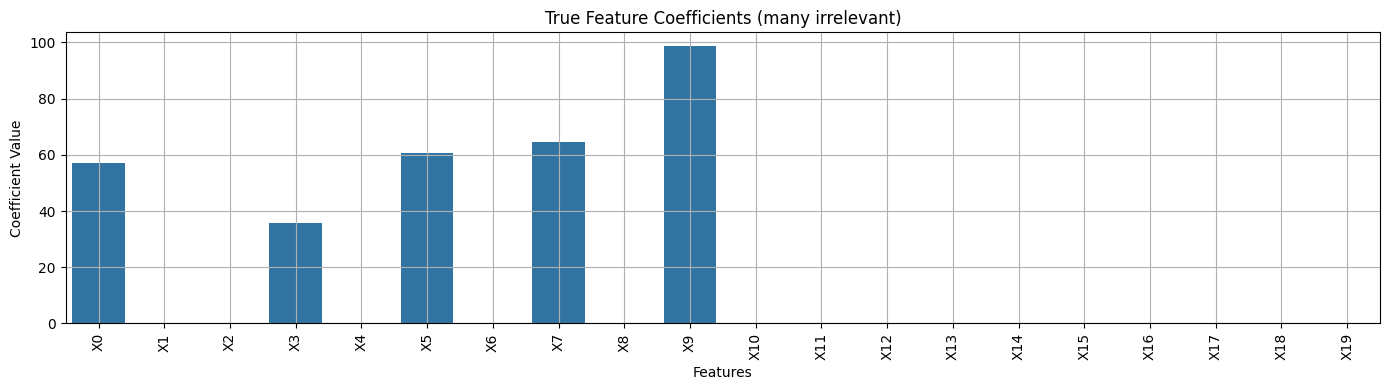

(50, 21)

In [3]:
df, coef = generate_data(plot=True)
df.shape

In [4]:
X = df.drop(columns=["y"])
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet Regression": ElasticNet(alpha=0.1, l1_ratio=0.5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    print(name)
    print(f"Train R2 score: {r2_train:.4f}")
    print(f"Test R2 score: {r2_test:.4f}")
    print()
    print('Model Parameters:', model.coef_)
    print('-' * 50)
    print('\n\n')

Linear Regression
Train R2 score: 0.9807
Test R2 score: 0.8258

Model Parameters: [ 65.71992935 -13.51459596   3.33636474  17.9859486   14.50522782
  65.52041535   4.4719679   76.35964424 -14.42618377 104.06891063
  18.66122    -13.78900358  -2.02726498 -14.51634764 -18.31178341
   8.89070315   6.31881797 -12.05080387  -8.45852607   3.39029258]
--------------------------------------------------



Ridge Regression
Train R2 score: 0.9791
Test R2 score: 0.8654

Model Parameters: [ 61.38759929  -9.49737247   2.4013457   19.33142987  14.95811515
  63.13407929   5.47946384  71.19141736 -11.01252464  99.76726753
  15.95088519 -12.82314924  -2.00342097 -11.92735618 -14.52698505
   6.83332681   4.41774951  -6.7827771   -8.36622304   4.42767818]
--------------------------------------------------



Lasso Regression
Train R2 score: 0.9807
Test R2 score: 0.8356

Model Parameters: [ 65.16018979 -12.72296927   3.23731185  18.16017374  14.30338577
  65.36763743   4.53382468  75.85235068 -13.6558026 

In [5]:
def plot_scores(model, alphas):
    train_scores = []
    test_scores = []
    
    for alpha in alphas:
        model.alpha = alpha
        model.max_iter = 10000
        model.fit(X_train, y_train)
    
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
    
        train_scores.append(r2_train)
        test_scores.append(r2_test)

    best_alpha = np.round(alphas[np.argmax(test_scores)], 2)
    
    plt.figure(figsize=(10, 5))
    plt.plot(alphas, train_scores, label="Train R2", marker='o')
    plt.plot(alphas, test_scores, label="Test R2", marker='o')
    plt.axvline(best_alpha, color='red', linestyle='--', label=f"Best Aplha = {best_alpha:.2f}")
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("R2 Score")
    plt.title(f"{model.__class__.__name__} Regression Performance Across Alphas")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return best_alpha

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test, true_coef=None, model_name=None):
    model.fit(X_train, y_train)
    estimated_coef = model.coef_

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    print(f"Model: {model_name or model.__class__.__name__}")
    print("Train R^2 Score:", round(r2_train, 4))
    print("Test  R^2 Score:", round(r2_test, 4))

    if true_coef is not None:
        indices = np.arange(len(true_coef))
        bar_width = 0.4

        plt.figure(figsize=(14, 6))
        plt.bar(indices - bar_width/2, true_coef, width=bar_width, label="True Coefficients", color='red')
        plt.bar(indices + bar_width/2, estimated_coef, width=bar_width, label=f"{model_name or model.__class__.__name__} Estimated", color='blue')
        plt.xlabel("Feature Index")
        plt.ylabel("Coefficient Value")
        plt.title(f"True vs Estimated Coefficients ({model_name or model.__class__.__name__})")
        plt.xticks(indices, [f"X{i}" for i in range(len(true_coef))], rotation=90)
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    return {
        'model': model,
        'estimated_coef': estimated_coef,
        'r2_train': r2_train,
        'r2_test': r2_test
    }

In [7]:
def plot_important_features(estimated_coef, feature_names=None, top_n=10, model_name="Model"):
    if feature_names is None:
        feature_names = [f"X{i}" for i in range(len(estimated_coef))]

    coef_abs = np.abs(estimated_coef)
    top_indices = np.argsort(coef_abs)[-top_n:][::-1]

    plt.figure(figsize=(10, 4))
    sns.barplot(
        x=[feature_names[i] for i in top_indices],
        y=estimated_coef[top_indices],
        palette="coolwarm"
    )
    plt.title(f"Top {top_n} Important Features - {model_name}")
    plt.ylabel("Coefficient Value")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Lasso or L1 Regularization  
Trained Lasso Regression model (L1 regularization). This method can drive less important feature coefficients to zero, performing both regularization and feature selection.

In [8]:
alphas = np.linspace(0.1, 20, 20)

In [9]:
alphas

array([ 0.1       ,  1.14736842,  2.19473684,  3.24210526,  4.28947368,
        5.33684211,  6.38421053,  7.43157895,  8.47894737,  9.52631579,
       10.57368421, 11.62105263, 12.66842105, 13.71578947, 14.76315789,
       15.81052632, 16.85789474, 17.90526316, 18.95263158, 20.        ])

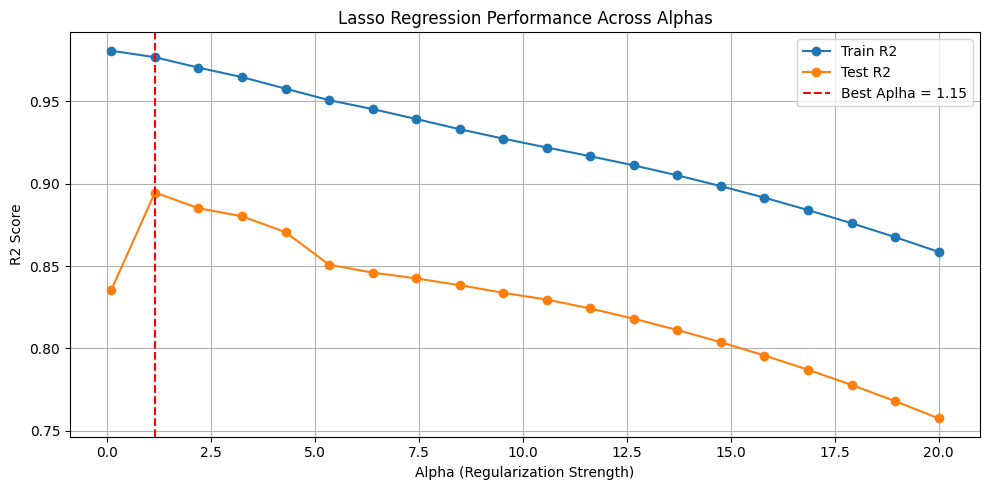

1.15


In [10]:
lasso_reg = Lasso()
best_alpha = plot_scores(lasso_reg, alphas)
print(best_alpha)

Model: Lasso
Train R^2 Score: 0.9767
Test  R^2 Score: 0.8947


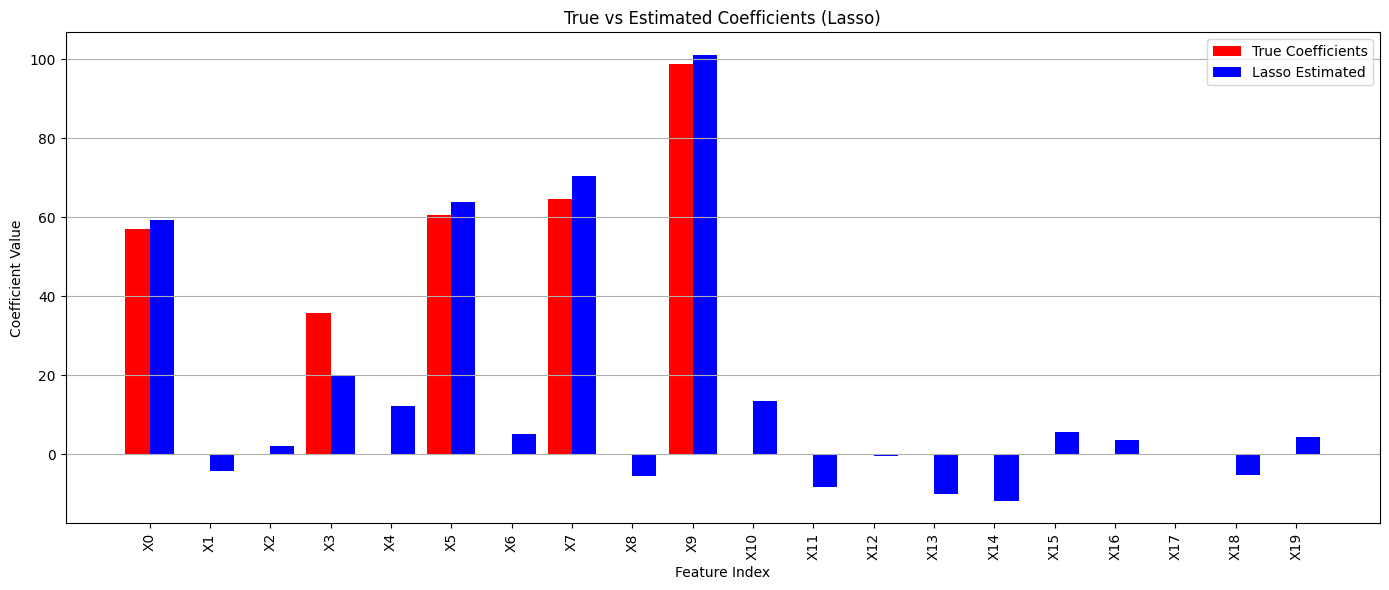

In [11]:
results_lasso = evaluate_model(Lasso(alpha=best_alpha, max_iter=10000, random_state=42), X_train, y_train, X_test, y_test, true_coef=coef, model_name="Lasso")

C:\Users\User\AppData\Local\Temp\ipykernel_6484\769078939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


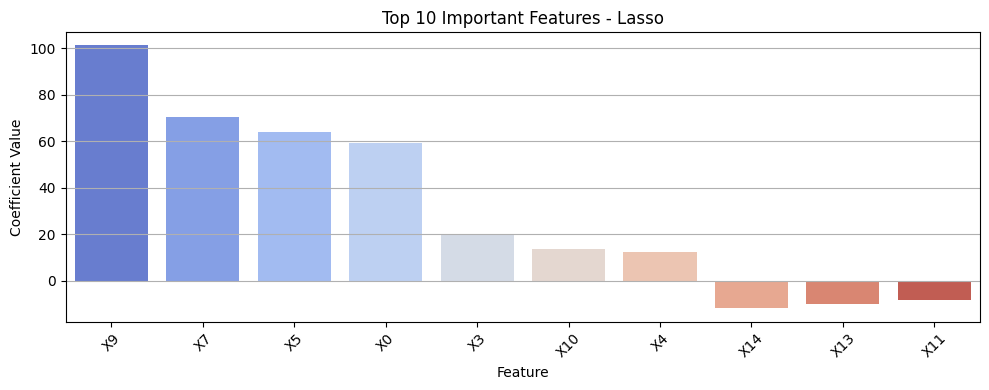

In [12]:
plot_important_features(
    estimated_coef=results_lasso["estimated_coef"],
    feature_names=[f"X{i}" for i in range(X_train.shape[1])],
    top_n=10,
    model_name="Lasso"
)

# Reidge or L2 Regularization  
Train a Ridge Regression model (L2 regularization). It penalizes large coefficients, reducing model variance and mitigating overfitting.

In [13]:
alphas

array([ 0.1       ,  1.14736842,  2.19473684,  3.24210526,  4.28947368,
        5.33684211,  6.38421053,  7.43157895,  8.47894737,  9.52631579,
       10.57368421, 11.62105263, 12.66842105, 13.71578947, 14.76315789,
       15.81052632, 16.85789474, 17.90526316, 18.95263158, 20.        ])

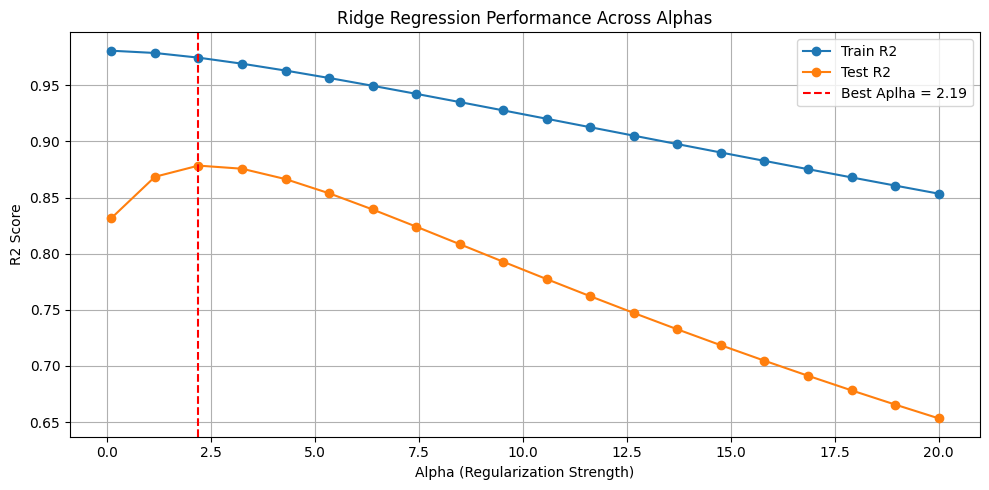

2.19


In [14]:
ridge_reg = Ridge()
best_alpha = plot_scores(ridge_reg, alphas)
print(best_alpha)

Model: Ridge
Train R^2 Score: 0.9745
Test  R^2 Score: 0.8784


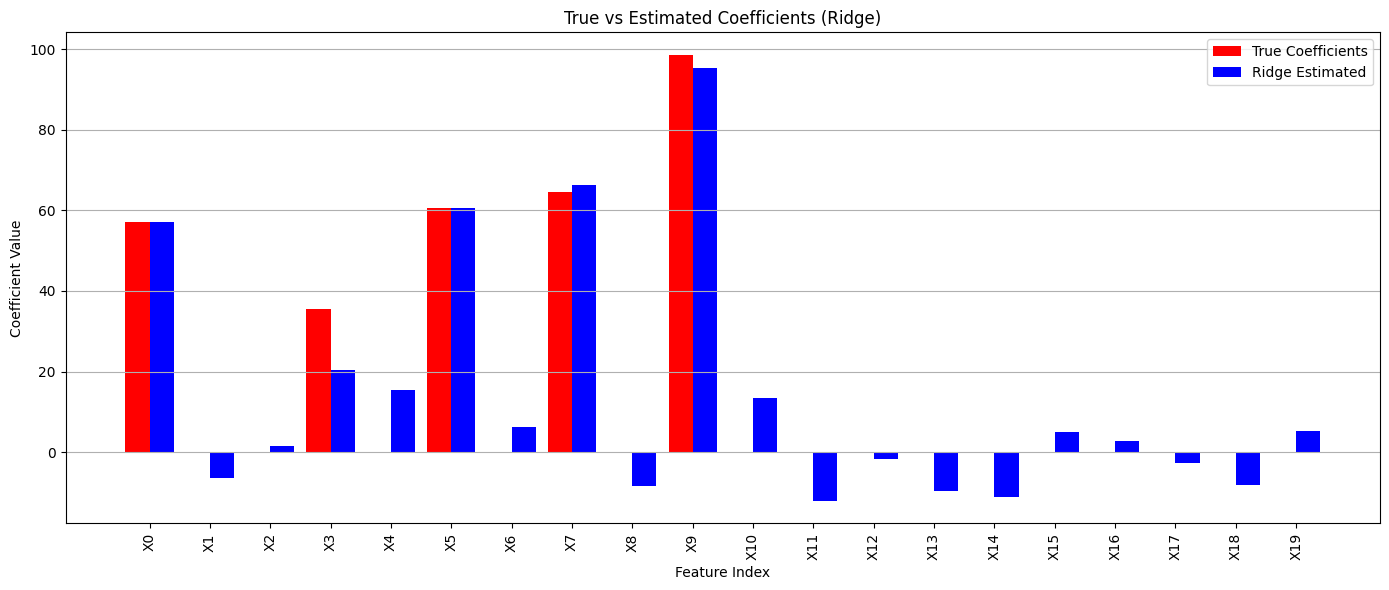

In [15]:
ridge_results = evaluate_model(Ridge(alpha=best_alpha, max_iter=10000, random_state=42), X_train, y_train, X_test, y_test, true_coef=coef, model_name="Ridge")

C:\Users\User\AppData\Local\Temp\ipykernel_6484\769078939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


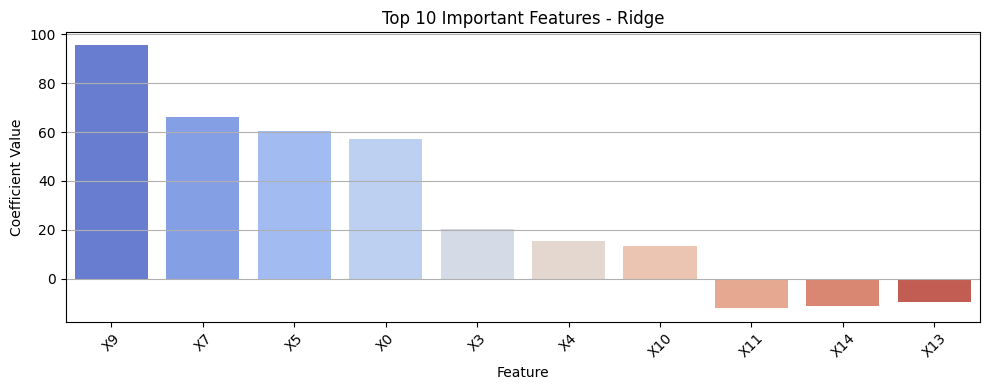

In [16]:
plot_important_features(
    estimated_coef=ridge_results["estimated_coef"],
    feature_names=[f"X{i}" for i in range(X_train.shape[1])],
    top_n=10,
    model_name="Ridge"
)

# ElasticNet Regularization

In [17]:
alphas

array([ 0.1       ,  1.14736842,  2.19473684,  3.24210526,  4.28947368,
        5.33684211,  6.38421053,  7.43157895,  8.47894737,  9.52631579,
       10.57368421, 11.62105263, 12.66842105, 13.71578947, 14.76315789,
       15.81052632, 16.85789474, 17.90526316, 18.95263158, 20.        ])

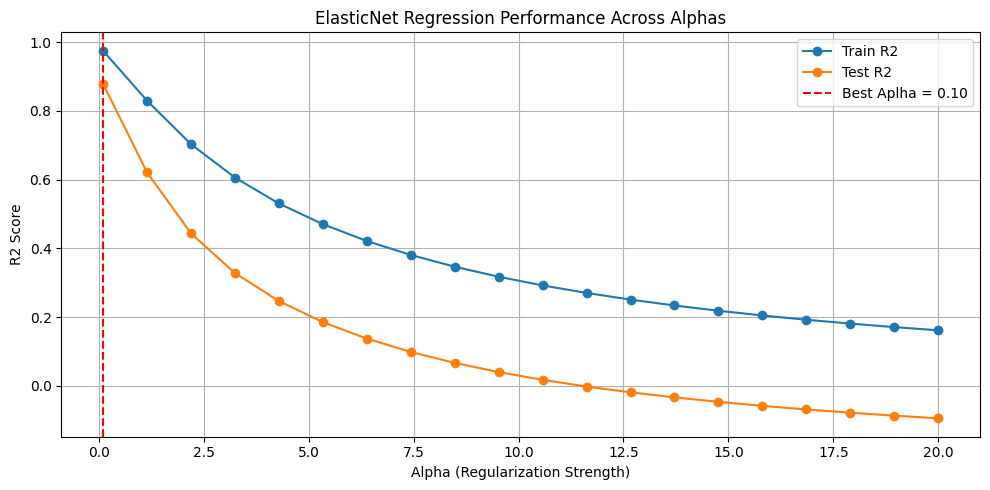

np.float64(0.1)

In [18]:
en_reg = ElasticNet(l1_ratio=0.5)
plot_scores(en_reg, alphas)

Model: ElasticNet
Train R^2 Score: 0.8793
Test  R^2 Score: 0.7033


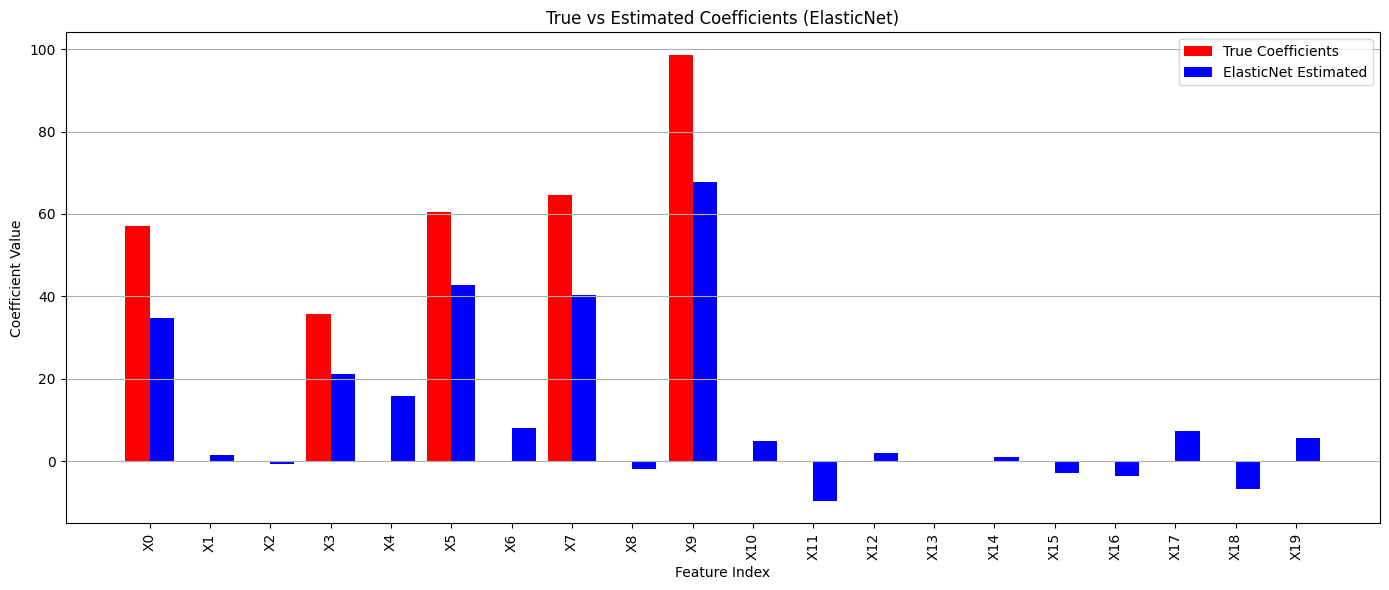

In [19]:
en_results = evaluate_model(ElasticNet(alpha=0.8, l1_ratio=0.5, max_iter=10000), X_train, y_train, X_test, y_test, true_coef=coef, model_name="ElasticNet")

C:\Users\User\AppData\Local\Temp\ipykernel_6484\769078939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


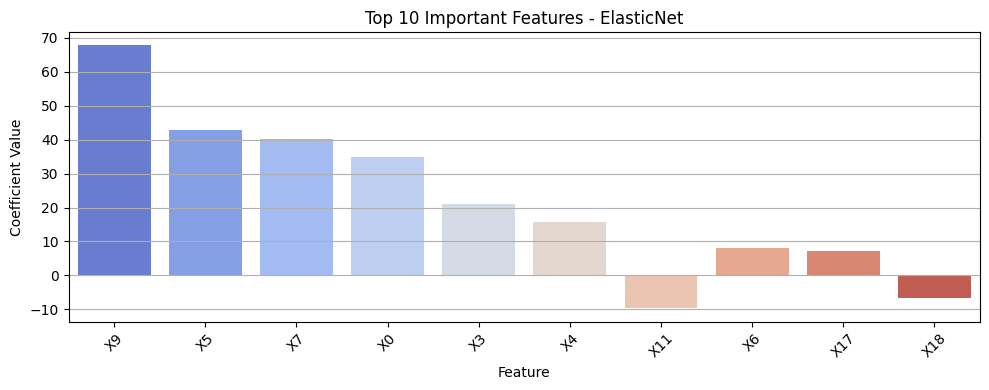

In [20]:
plot_important_features(
    estimated_coef=en_results["estimated_coef"],
    feature_names=[f"X{i}" for i in range(X_train.shape[1])],
    top_n=10,
    model_name="ElasticNet"
)